Компания предлагает следующие варианты туров:

- Таиланд — 100 000 рублей;
- Турция — 60 000 рублей;
- Мальдивы — 200 000 рублей;
- Санкт-Петербург — 10 000 рублей;
- Камчатка — 150 000 рублей.

Таблица представлена следующими полями:

- user_id — идентификатор пользователя, зашедшего на сайт;

- data — дата посещения сайта;

- group — группа теста (контрольная — А или тестовая — B);

- purchase — признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет);

- price — цена купленного тура (если покупка не состоялась, цена равна 0).

In [1]:
import pandas as pd
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## 1. Анализ структуры данных, пердобработка

In [2]:
# Проверка данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


In [3]:
# Переводим признак data в формат datetime
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')

# Проверяем данные на наличие пропусков
data.isna().sum()

user_id     0
date        0
group       0
purchase    0
price       0
dtype: int64

In [4]:
# проверим длительность теста в каждой группе

print(data.groupby('group')['date'].agg(['min','max']))


             min        max
group                      
A     2021-01-02 2021-01-24
B     2021-01-02 2021-01-24


> Длительность теста в группах совпадает

**Выполним проверку на пересечение пользователей в каждой группе**

In [5]:
# пользователи в каждой группе
users_A = set(data.loc[data['group'] == 'A', 'user_id'])
users_B = set(data.loc[data['group'] == 'B', 'user_id'])

# пересечение (те, кто попал в обе группы)
users_in_both = users_A & users_B

print(f"Пересечение пользователей: {len(users_in_both)}")

Пересечение пользователей: 1895


In [6]:
# исключаем этих пользователей из датафрейма
clean_data = data[~data['user_id'].isin(users_in_both)]

print(f'Количетсво строк до очистки {len(data)}\nКоличество строк после очистки {len(clean_data)}')

Количетсво строк до очистки 294478
Количество строк после очистки 290688


### Вывод:

1. Выполнен предварительный анализ данных
2. Признак date переведён в формат datetime
3. Выполнена пересечений пользователей в гурппах
4. Исплючены пересечения пользователй

## 2. Первичный анализ результатов A/B-тестирования:

In [7]:
# Рассчёт вспомагательных показателей групп

pivot_data = clean_data.pivot_table(
    index = 'group',
    values = ['user_id', 'purchase', 'price'],
    aggfunc={
        'user_id':'count',
        'purchase':'sum',
        'price':'sum'
             }
)

pivot_data

,price,purchase,user_id
group,,,
A,1417780000,17487,145307
B,1533010000,17290,145381


> Согласно вспомагательным параметрам:

- количество посещений сайта и общая сумма покупок выше в **группе B**

- общее количество покупок выше в **группе А**

In [8]:
pivot_data['avg_check'] = round(data.groupby('group')['price'].agg('mean'))
pivot_data['conversion'] = round(pivot_data['purchase']/pivot_data['user_id'],3)
pivot_data

,price,purchase,user_id,avg_check,conversion
group,,,,,
A,1417780000,17487,145307,9757.0,0.120
B,1533010000,17290,145381,10552.0,0.119


> По предварительному анализу можно сделат вывод:

- Конверсия в группе А немного превышает конверсию в группе B

- При этом средний чек в группе В выше, чем в группе А

In [9]:
# сводная таблица: количество продаж по группам и ценам
pivot_sales = clean_data.pivot_table(
    index='price',
    columns='group',
    values='purchase',
    aggfunc='sum'
)

pivot_sales

group,A,B
price,,
0,0,0
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


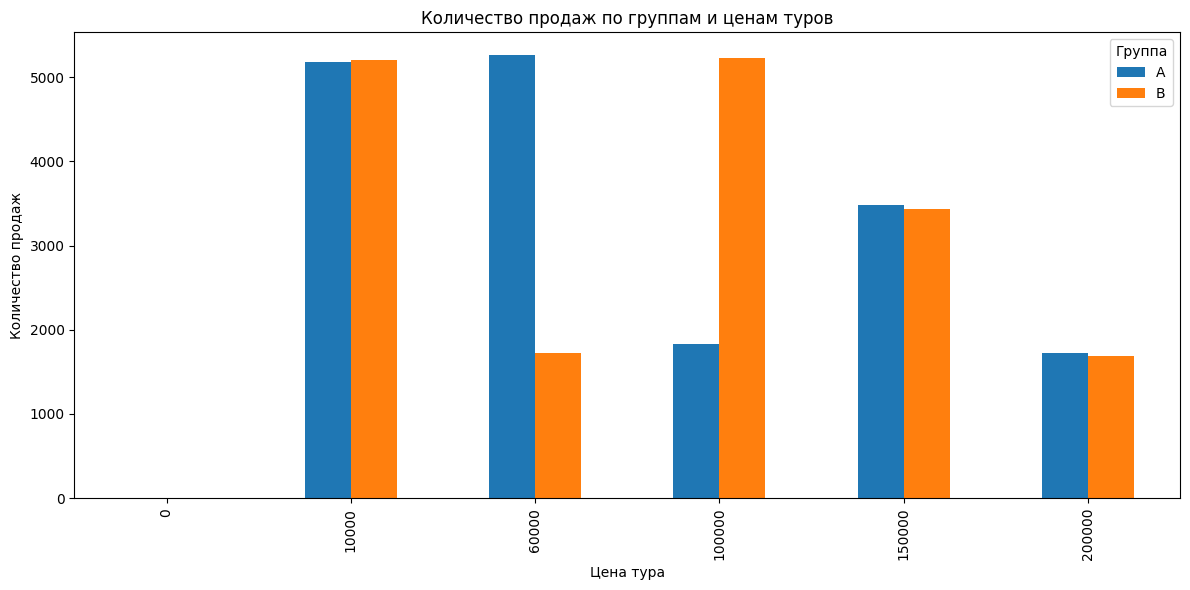

In [10]:
import matplotlib.pyplot as plt

# график для сравнения
pivot_sales.plot(kind='bar', figsize=(12,6))

plt.title("Количество продаж по группам и ценам туров")
plt.xlabel("Цена тура")
plt.ylabel("Количество продаж")
plt.legend(title="Группа")
plt.tight_layout()
plt.show()

### Вывод



- Покупки туров с ценовой категорией 60000 значительно превашают в группе А

- Покупки туров с ценовой категорией 100000 значительно превашают в группе В

*Данный фактор обосновывает более высокую сумму покупок в группе В*

> Покупки туров в остальных ценовых категория примерно одинаковы

## 3. Анализ данных на предмет стабилизации метрик:

In [11]:
# Датасет с ежедневными датами результатов A/B теста

daily_data = clean_data.pivot_table(
    index=['date', 'group'],
    values=['user_id', 'purchase', 'price'],
    aggfunc={
        'user_id': 'count',
        'purchase': 'sum',
        'price': 'sum',
    }
).reset_index()

# Добавляем признак с конверсией

daily_data['conversion'] = daily_data['purchase']/daily_data['user_id']

daily_data = daily_data.rename(columns={'user_id':'visit_count'})

daily_data.head()

,date,group,price,purchase,visit_count,conversion
0,2021-01-02,A,29410000,359,2854,0.125788
1,2021-01-02,B,29660000,345,2861,0.120587
2,2021-01-03,A,62000000,748,6596,0.113402
3,2021-01-03,B,65960000,754,6619,0.113914
4,2021-01-04,A,64250000,799,6566,0.121687


In [12]:
# вычисляем кумулятивную сумму - сумма покупок
daily_data['cum_price'] = daily_data.groupby(['group'])['price'].cumsum()

# вычисляем кумулятивную сумму - количество покупок
daily_data['cum_purchase'] = daily_data.groupby(['group'])['purchase'].cumsum()


# вычисляем кумулятивную сумму - количество посещений
daily_data['cum_visit_count'] = daily_data.groupby(['group'])['visit_count'].cumsum()

# Вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_purchase'] / daily_data['cum_visit_count']

#Вычисляем  кумулятивный средний чек
daily_data['cum_avg_check'] = daily_data['cum_price'] / daily_data['cum_purchase']

daily_data.head()

,date,group,price,purchase,visit_count,conversion,cum_price,cum_purchase,cum_visit_count,cum_conversion,cum_avg_check
0,2021-01-02,A,29410000,359,2854,0.125788,29410000,359,2854,0.125788,81922.005571
1,2021-01-02,B,29660000,345,2861,0.120587,29660000,345,2861,0.120587,85971.014493
2,2021-01-03,A,62000000,748,6596,0.113402,91410000,1107,9450,0.117143,82574.525745
3,2021-01-03,B,65960000,754,6619,0.113914,95620000,1099,9480,0.115928,87006.369427
4,2021-01-04,A,64250000,799,6566,0.121687,155660000,1906,16016,0.119006,81668.415530


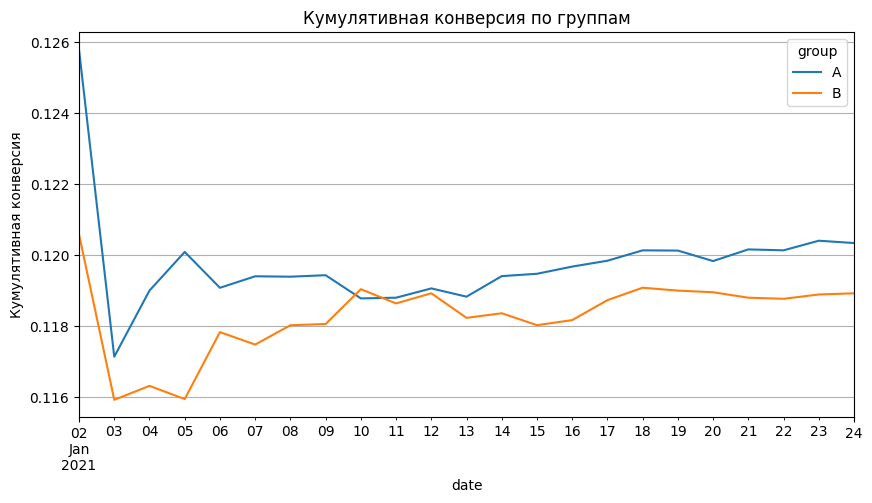

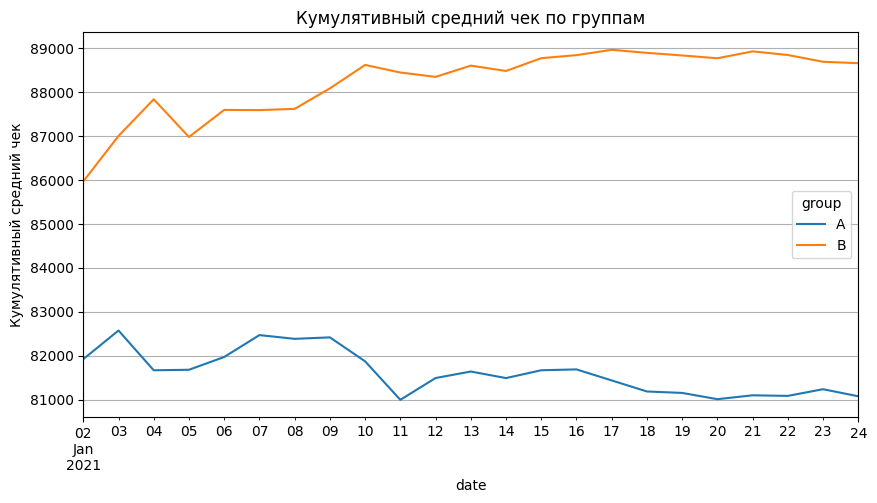

In [13]:
daily_data.pivot(
    index='date', 
    columns='group',
    values='cum_conversion'
    ).plot(figsize=(10, 5), title="Кумулятивная конверсия по группам")
    
plt.ylabel("Кумулятивная конверсия")
plt.grid(True)
plt.show()

# строим кумулятивный средний чек
daily_data.pivot(
    index='date', 
    columns='group', 
    values='cum_avg_check'
    ).plot(figsize=(10, 5), title="Кумулятивный средний чек по группам")

plt.ylabel("Кумулятивный средний чек")
plt.grid(True)
plt.show()

### Вывод

> Визуальный анализ показывает, что кумулятивные признаки стабилизируеются во времени

- Куммулятивная конверсия ниже в гурппе B
- Куммулятивный средний чек ниже в группе А

> **Резултаты кумулятивных признаков сходятся с результатами первичного анализа (см. п.2)**

## 4. Cтатистический анализ результатов A/B-тестирования, доверительные интервалы:

> Имеем датасет двух групп, по 23 наблюдения в каждой.

***для начала воспользуемся статистическим тестом χ²***

> Нулевая гипотеза **разница пропорция A и B равно некоторому заданному числу *value* (т.е. )

### 4.1. Статистические тесты

In [14]:
# Группируем данные по количеству посестителей и количество продаж

conv_piv = clean_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
    ).reset_index()
conv_piv

,group,sum,count
0,A,17487,145307
1,B,17290,145381


In [15]:
from statsmodels.stats.proportion import proportions_chisquare

alpha = 0.05 # уровень значимости
# вычисляем значение p-value для Z-теста для пропорций
_, p_value, c = proportions_chisquare(
    count=conv_piv['sum'], #число «успехов»
    nobs=conv_piv['count'] #общее число наблюдений
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.239
У нас нет оснований отвергнуть нулевую гипотезу


> p-value больше заданного уровня значимости *alpha*, соответственно предварительно делаем вывод - ***разницы в оформлении посадочных страниц нет***

**Далее проведём дополнительный статистический тест по среднему чеку (по дням) в каждой из групп**

In [16]:
# Создаём признак avg_check в датасете daily_data

daily_data['avg_check'] = round(daily_data['price']/daily_data['purchase'])

# Сгруппрованный датасет с вычисленными признаками

mask_a = daily_data[daily_data['group']=='A']
mask_b = daily_data[daily_data['group']=='B']

Text(0.5, 0, 'Средний чек')

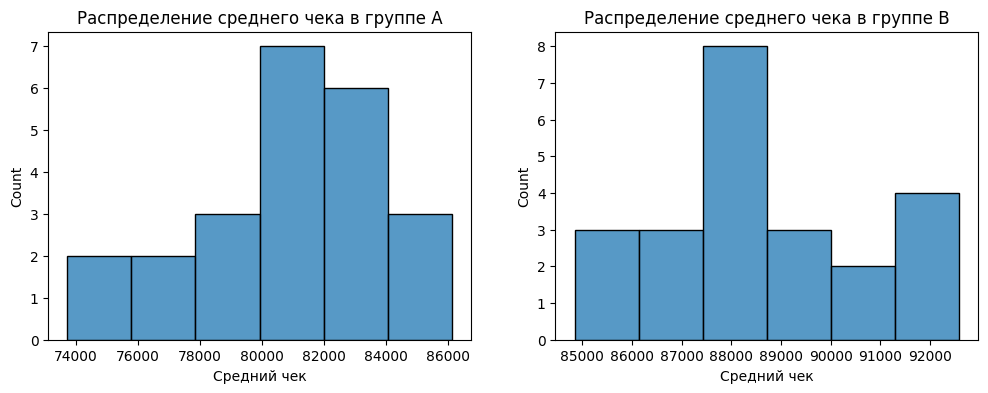

In [17]:
# Визуальная проверка на нормальность по среднему чеку

import seaborn as sns
import matplotlib.pyplot as plt

# создаём два графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='avg_check', data=mask_a, ax=axes[0])
axes[0].set_title("Распределение среднего чека в группе A")
axes[0].set_xlabel("Средний чек")

sns.histplot(x='avg_check', data=mask_b, ax=axes[1])
axes[1].set_title("Распределение среднего чека в группе B")
axes[1].set_xlabel("Средний чек")


> Визуально распределение данных похоже на нормальное

In [18]:
# Проведём статистический тест на нормальность распределения

from scipy.stats import shapiro

alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(mask_a['avg_check'])
shapiro_result_b = shapiro(mask_b['avg_check'])

# сравниваем полученное p-value для группы А с уровнем значимости
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")

p-value группы А 0.25
Принимаем нулевую гипотезу. Распределение в группе А является нормальным
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределение в группе B является нормальным


> **Статистический тест подтверждает нормалность распределение данных среднего чека**

Так-как:
- сравниваем две независымые группы
- данные распредлены наормально

**Воспользуемся двухвыборочным t-критерием**

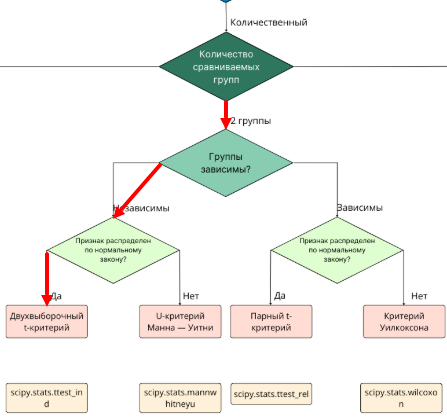

In [19]:
from scipy.stats import ttest_ind

alpha = 0.05 #уровень значимости
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=mask_a['avg_check'],
    b=mask_b['avg_check'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


> Согласно статистическому тесту, по признаку среднего чекa - **вариат В эффективнее варианта А**

### 4.2. Доверительные интервалы

> 1. **Найдём доверительный интервал по среднему чеку**

In [20]:
# Находим средний дневной чек и стандартное отклонение, разделим на группы. 
# Для этого воспользуемся ранее сделанными вспосогательными таблицами mask_a, mask_b

group_a = mask_a.groupby('group')['avg_check'].agg(['mean','std'])
print(group_a)

group_b = mask_b.groupby('group')['avg_check'].agg(['mean','std'])
print(group_b)


               mean          std
group                           
A      80969.347826  3096.388506
              mean          std
group                          
B      88575.73913  2196.705844


In [21]:
# Далее через функцию вычислим доверительные интервалы для групп А и В

from scipy.stats import norm

def z_mean_conf_interval(x_mean, sigma, n, gamma=0.95):  
    alpha = 1 - gamma  # уровень значимости
    z_crit = -norm.ppf(alpha/2)  # z-критическое
    eps = z_crit * sigma/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps  # левая (нижняя) граница
    upper_bound = x_mean + eps  # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

# строим доверительный интервал для среднего при известном СКО
lower_bound_a, upper_bound_a = z_mean_conf_interval(group_a['mean'], sigma = group_a['std'], n = 23)

# выводим результат
print(f'Доверительный интервал в группе A: ({int(lower_bound_a.iloc[0])}, {int(upper_bound_a.iloc[0])})')

# строим доверительный интервал для среднего при известном СКО
lower_bound_b, upper_bound_b = z_mean_conf_interval(group_b['mean'], sigma = group_b['std'], n = 23)

# выводим результат
print(f'Доверительный интервал в группе B: ({int(lower_bound_b.iloc[0])}, {int(upper_bound_b.iloc[0])})')

Доверительный интервал в группе A: (79703, 82234)
Доверительный интервал в группе B: (87677, 89473)


> 2. **Найдём доверительный интервал для конверсий групп А и В**

In [22]:
# Добавим в группы А и В признаки конверсии и количества пользователей

conv_piv['conversion'] = conv_piv['sum'] / conv_piv['count']

group_a['conversion'] = float(conv_piv[conv_piv['group'] == 'A']['conversion'].iloc[0])
group_a['user_count'] = float(conv_piv[conv_piv['group'] == 'A']['count'].iloc[0])
group_b['conversion'] = float(conv_piv[conv_piv['group'] == 'B']['conversion'].iloc[0])
group_b['user_count'] = float(conv_piv[conv_piv['group'] == 'B']['count'].iloc[0])


In [23]:
# Вычисляем доверительный интервал конверсии

def proportion_conf_interval(x_p, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z-критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 # погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

# строим доверительный интервал для конверсии в группе А
lower_bound_a, upper_bound_a  = proportion_conf_interval(
    x_p=group_a['conversion'], # выборочная пропорция
    n=group_a['user_count'] # размер выборки
)

# строим доверительный интервал для конверсии в группе B
lower_bound_b, upper_bound_b  = proportion_conf_interval(
    x_p=group_b['conversion'], # выборочная пропорция
    n=group_b['user_count'] # размер выборки
)

# выводим результат
print(f'Доверительный интервал для конверсии в группе А: {round(lower_bound_a.iloc[0] * 100, 2), round(upper_bound_a.iloc[0] * 100, 2)}')
print(f'Доверительный интервал для конверсии в группе B: {round(lower_bound_b.iloc[0] * 100, 2), round(upper_bound_b.iloc[0] * 100, 2)}')

Доверительный интервал для конверсии в группе А: (11.87, 12.2)
Доверительный интервал для конверсии в группе B: (11.73, 12.06)


> 3. **Вычислим разницу конверсий в гурппах А и В**

In [24]:
# Функция вычислеиня разницы конверсий

def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

In [25]:
# размеры выборок групп А и B
n = [group_a['user_count'].iloc[0], group_b['user_count'].iloc[0]]
# выборочная пропорция групп A и B
x_p = [group_a['conversion'].iloc[0], group_b['conversion'].iloc[0]]


# строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)


# выводим результат
print('Доверительный интервал для разности конверсий: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


## Заключение

1. Выполнена предварительная педобработка данных:
    - анализ признаков и групп;
    - анализ длительности тестирования;
    - устранение пересечений пользователей в группах.
2. Согласно первичному анализу результатов: 
    - конверсии в обеих группах совпадают, что указывает на **равнзначность вариантов А и В**;
    - средний чек выше в варианте В, что указывает более высокую эффективность.
3. Выполнен анализ на предмент стабилизации метрик:
    - Вычисленны вспомогательные кумулятивные признаки, построены графики зависимости;
    - Графика подтверждают предварительный анализ:
        - значительной разницы в кумулятивных конверсиях не наблюдается;
        - комулятивный средний чек выше в **группе В**,
4. Выполены статистические тесты:
    - статистический тест Xи^2 конверсий **не отвергает нулевую гипотезу** - разницы в вариантах А и В нет;
    - разница доверительных интервалов в конверсиях подтверждает, что вариант А и В равнозначны:
    - статистический тест среднего дневного чека **отвергает нулевую гипотезу** - вариант В эффективнее;
    - доверительная веротяность среднего чека выше в варианте В;

### На основании всего вышеперечисленного рекомендуется продолжить тест для увеличения выборки признака *'средний дневной чек'*, после завершения теста выполнить повторный анализ
